
# BlocPower data: Buildings in New York City

The four main sections of this notebook are:
1. [Setup](#Setup)
2. [Model energy usage in kWh of buildings](#2.-Model-energy-usage-in-kWh-of-buildings)
3. [Detect buildings that consume energy inefficiently](#3.-Detect-buildings-that-consume-energy-inefficiently)
4. [Export data and models to RStudio](#4.-Export-data-and-models-to-RStudio)

A lot of our findings were based on [this article](http://www.informs-sim.org/wsc11papers/082.pdf) by a group of researchers from 
+ IBM T.J. Watson Research Center, 
+ CUNY Institute for Urban Systems and 
+ McMaster University. 


# 1. Setup
## Load data 
+ BlocPower data
+ Public heating and cooling data in New York


First click on the 1001 icon in the top right, to open the data panel:
<div><img src="https://raw.githubusercontent.com/IBMDataScience/SparkSummitDemo/master/Screenshots/dataicon.png" width=100 align="left"
/></div>

In [1]:

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# @hidden_cell
# This function is used to setup the access of Spark to your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def set_hadoop_config_with_credentials_92c679820c6e49a78bfdc51c91ebdd53(name):
    """This function sets the Hadoop configuration so it is possible to
    access data from Bluemix Object Storage using Spark"""

    prefix = 'fs.swift.service.' + name
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + '.auth.url', 'https://identity.open.softlayer.com'+'/v3/auth/tokens')
    hconf.set(prefix + '.auth.endpoint.prefix', 'endpoints')
    hconf.set(prefix + '.tenant', '7babac2c6d62406abd107c4512e6ede0')
    hconf.set(prefix + '.username', '116a6ab15f6a44028616206107a55761')
    hconf.set(prefix + '.password', 'z3gbA^[]_,,C^T9L')
    hconf.setInt(prefix + '.http.port', 8080)
    hconf.set(prefix + '.region', 'dallas')
    hconf.setBoolean(prefix + '.public', False)

# you can choose any name
name = 'keystone'
set_hadoop_config_with_credentials_92c679820c6e49a78bfdc51c91ebdd53(name)

df_data_1 = sqlContext.read.format('com.databricks.spark.csv')\
  .options(header='true', inferschema='true')\
  .load("swift://DSXDemos." + name + "/BlocPower_T.csv")
df_data_1.take(5)


[Row(UTSUM_Electricity_Usage=u'117,870 kWh', INFO_Year of Construction=u'1955', INFO_Number of Stories=4, INFO_Total Square Feet=u'14,600', PLEI_1_Quantity=1, PLEI_3_Quantity=u'2'),
 Row(UTSUM_Electricity_Usage=u'16,207 kWh', INFO_Year of Construction=u'1940', INFO_Number of Stories=1, INFO_Total Square Feet=u'600', PLEI_1_Quantity=1, PLEI_3_Quantity=u''),
 Row(UTSUM_Electricity_Usage=u'15,564 kWh', INFO_Year of Construction=u'1920', INFO_Number of Stories=2, INFO_Total Square Feet=u'6,000', PLEI_1_Quantity=2, PLEI_3_Quantity=u'1'),
 Row(UTSUM_Electricity_Usage=u'25,851 kWh', INFO_Year of Construction=u'1965', INFO_Number of Stories=1, INFO_Total Square Feet=u'5,000', PLEI_1_Quantity=6, PLEI_3_Quantity=u'1'),
 Row(UTSUM_Electricity_Usage=u'32,343 kWh', INFO_Year of Construction=u'1930', INFO_Number of Stories=3, INFO_Total Square Feet=u'4,196', PLEI_1_Quantity=1, PLEI_3_Quantity=u'1')]

In [2]:

df_data_2 = sqlContext.read.format('com.databricks.spark.csv')\
  .options(header='true', inferschema='true')\
  .load("swift://DSXDemos." + name + "/HDD-Features.csv")
df_data_2.take(5)


[Row(domestic_gas=0.096226455, heating_gas=0.366193236),
 Row(domestic_gas=0.322599638, heating_gas=0.57959223),
 Row(domestic_gas=0.032705972, heating_gas=0.036460695),
 Row(domestic_gas=0.02750427, heating_gas=0.23466382),
 Row(domestic_gas=0.322599638, heating_gas=0.57959223)]

In [3]:

df_data_3 = sqlContext.read.format('com.databricks.spark.csv')\
  .options(header='true', inferschema='true')\
  .load("swift://DSXDemos." + name + "/CDD-HDD-Features.csv")
df_data_3.take(5)


[Row(Property Name=u'ChurchofStCeciliaReport', plug_load_consumption=11.65140596, ac_consumption=0.983531348, domestic_gas=0.096226455, heating_gas=0.366193236),
 Row(Property Name=u'69thLaneStudio', plug_load_consumption=32.76988438, ac_consumption=5.008371873, domestic_gas=0.322599638, heating_gas=0.57959223),
 Row(Property Name=u'UnitarianChurchofStatenIsland', plug_load_consumption=2.345049272, ac_consumption=0.296133819, domestic_gas=0.032705972, heating_gas=0.036460695),
 Row(Property Name=u'SSolowayandSonsPIPPrinting', plug_load_consumption=4.618817159, ac_consumption=0.765188561, domestic_gas=0.02750427, heating_gas=0.23466382),
 Row(Property Name=u'SunnysideJewishCenterReport', plug_load_consumption=9.323896186, ac_consumption=1.23432624, domestic_gas=0.322599638, heating_gas=0.57959223)]

#### Now we can rename the data frames to be more meaningful:

In [4]:
df2 = df_data_1   #BlocPower_T.csv
dfHDD = df_data_2 #HDD-Features.csv
dfCH = df_data_3  #CDD-HDD-Features.csv

## Import Spark and Python Libraries

In [5]:
import numpy as np
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# 2. Model energy usage in kWh of buildings

## Inspect the first few rows of the BlocPower data
+ UTSUM_Electricity_Usage .- annual energy usage of each building in measure in kWh
+ INFO_Year of Construction .- year when building was constructed
+ INFO_Number of Stories .- number of stories of each building
+ INFO_Total Square Feet .- square feet of each building
+ PLEI_1_Quantity .- number of plugged equipment (e.g., microwaves, computers, ...)
+ PLEI_3_Quantity .- same as PLEI_1 
## Data Preparation
+ On the first column (electricity usage), we need to reformat the values to get an actual number (e.g., 117,870 kWh to 117870)
+ On the 4th column (square feet), we need to get rid of the commas (e.g., 14,600 to 14600)
+ Notice that there are missing values

In [6]:
df2.show(5)

+-----------------------+-------------------------+----------------------+----------------------+---------------+---------------+
|UTSUM_Electricity_Usage|INFO_Year of Construction|INFO_Number of Stories|INFO_Total Square Feet|PLEI_1_Quantity|PLEI_3_Quantity|
+-----------------------+-------------------------+----------------------+----------------------+---------------+---------------+
|            117,870 kWh|                     1955|                     4|                14,600|              1|              2|
|             16,207 kWh|                     1940|                     1|                   600|              1|               |
|             15,564 kWh|                     1920|                     2|                 6,000|              2|              1|
|             25,851 kWh|                     1965|                     1|                 5,000|              6|              1|
|             32,343 kWh|                     1930|                     3|                

## Define Functions To Clean and Prepare Data

In [7]:
# define cleaning functions
def energy(v): # reformat the values to get an actual number (e.g., 117,870 kWh to 117870)
    v = v.encode('ascii','ignore').split(' ')[0].replace(',','')
    return np.nan if(v=='') else float(v)
def age(v): # computes the age of a buildings, given the year of construction
    v = v.encode('ascii','ignore')
    return 2016.0-float(v) if(len(v)==4) else np.nan
def stories(v):
    return float(v)
def sqFeet(v): # get rid of commas 
    v = v.encode('ascii','ignore').replace(',','')
    return np.nan if(v=='') else float(v) 
def plei(v): # in the PLEI columns, missing values can be interpeted as 0 plugged equipment
    try:
        vv = float(v)
    except:
        vv = 0.0
    return vv 
# Define udf's to apply the defined function to the Spark dataframe
udfEnergy = udf(energy, DoubleType())
udfAge = udf(age, DoubleType())
udfStories = udf(stories, DoubleType())
udfSqFeet = udf(sqFeet, DoubleType())
udfPlei = udf(plei, DoubleType())

## Apply Data Preparation Functionalities to Dataframe

In [8]:
dfN = df2.withColumn("UTSUM_Electricity_Usage", udfEnergy("UTSUM_Electricity_Usage")) \
         .withColumn("INFO_Year of Construction", udfAge("INFO_Year of Construction")) \
         .withColumn("INFO_Number of Stories", udfStories("INFO_Number of Stories")) \
         .withColumn("INFO_Total Square Feet", udfSqFeet("INFO_Total Square Feet")) \
         .withColumn("PLEI_1_Quantity", udfPlei("PLEI_1_Quantity")) \
         .withColumn("PLEI_3_Quantity", udfPlei("PLEI_3_Quantity")).cache()
dfN = dfN.withColumnRenamed("UTSUM_Electricity_Usage","energy") \
           .withColumnRenamed("INFO_Year of Construction","age") \
           .withColumnRenamed("INFO_Number of Stories","number_stories") \
           .withColumnRenamed("INFO_Total Square Feet","square_feet") \
           .withColumnRenamed("PLEI_1_Quantity","plei_1") \
           .withColumnRenamed("PLEI_3_Quantity","plei_3")            

## Fill in the missing values with an average

In [9]:
# compute avergae of non-missing energy and age
energy_mean = np.nanmean(np.asarray(dfN.select("energy").rdd.map(lambda r: r[0]).collect()))
age_mean = np.nanmean(np.asarray(dfN.select("age").rdd.map(lambda r: r[0]).collect()))
# fill missing values with the computed average
dfN = dfN.na.fill({"energy": energy_mean, "age": age_mean})

In [10]:
# define spark dataframe to be written to our objetc store
dfOut = dfN.select('energy', 'age', 'number_stories','square_feet','plei_1','plei_3')

## Form a feature matrix and scale the columns

In [11]:
# use the .toPandas() function to map Spark dataframes to pandas dataframes
dfNp = dfN.toPandas()
dfHDDp = dfHDD.toPandas()
# concatenate two pandas dataframes
feat = pd.concat([dfNp, dfHDDp], axis=1)
# get the column names of the concatenated dataframe
cols = feat.columns
# scale data to prepare for regression model 
from sklearn import preprocessing
scaler = preprocessing.MaxAbsScaler() 
feat = scaler.fit_transform(feat)
# define a new dataframe with the scaled data
dfScaled = pd.DataFrame(feat,columns=cols)

## Explore the correlations

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
pyplot.style.use('ggplot')
ff = pd.tools.plotting.scatter_matrix(dfScaled, diagonal='hist',figsize=(10,10))

ImportError: No module named _tkinter

## Linear regression model 

Hypothesis: energy usage (kWh) can be explained with building characteristics: 
+ Age of the building 
+ Square feet 
+ Number of stories 
+ Total plugged equipment, ...

In [15]:
# get a list of the features used to explain energy
features = dfScaled.columns.tolist()
response = ['energy']
features.remove(response[0])
# import regression solver
from sklearn import linear_model
# declare a linear regression model 
lr = linear_model.LinearRegression(fit_intercept=True)
# define response variable: energy usage
y = np.asarray(dfScaled[response]) 
# define features
X = dfScaled[features]
# fit regression model to the data
regr = lr.fit(X,y)
coefs = regr.coef_[0]
# collect regression coefficients
dataRegQ = []
dataRegQ.append(('Intercept', regr.intercept_[0]))
for i in range(len(features)):
    dataRegQ.append((features[i],coefs[i]))
# compute energy predictions using our fitted model     
yh = regr.predict(X)
# import package to compute the R-squared quality metric
from sklearn.metrics import r2_score
# print results
print 'R-Squared: ', r2_score(y,yh)
pd.DataFrame(dataRegQ,columns=['feature_name','coefficient']) #.head()

R-Squared:  0.71750454564


,feature_name,coefficient
0,Intercept,-0.067143
1,age,-0.023500
2,number_stories,0.048774
3,square_feet,0.777122
4,plei_1,0.312308
5,plei_3,0.122954
6,domestic_gas,0.229171
7,heating_gas,0.143661


## Visualize the model accuracy
+ The blue dots represent the observed energy versus the predicted energy by our trained model
+ The black dotted line is at 45 degrees and represents the perfect model
+ The closer the blue dots are to the black dotted line, the better the model fits the data

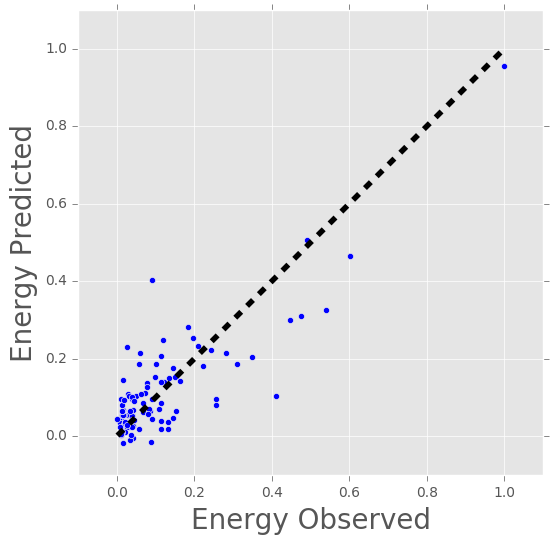

In [16]:
fig, ax = plt.subplots()
ax.scatter(y, yh)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Energy Observed',fontsize=20)
ax.set_ylabel('Energy Predicted',fontsize=20)
ax.axis([-0.1, 1.1, -0.1, 1.1])
plt.gcf().set_size_inches( (6, 6) )
plt.show()

# 3. Detect buildings that consume energy inefficiently

## Engineered characteristics of heating and cooling systems for the buildings

In [17]:
dfCH = dfCH.toPandas()
# get the numerical features
dfR = dfCH[['plug_load_consumption','ac_consumption','domestic_gas','heating_gas']]
# scale features with the max value of each column
dfN = dfR/dfR.max()
# concatenate scaled features and buildings name
dfCH_n = pd.concat((dfN, dfCH['Property Name']),1)

## Identify the buildings that consume energy inefficiently
+ Air conditioner
+ Plugged-in equipment (microwaves, computers, refrigerators, ...)
+ Gas for domestic usage
+ Gas for heating

For example, the following buildings consume AC inefficiently:

In [18]:
cname = 'ac_consumption' #'heating_gas'
dfCH_n[dfCH_n[cname]>dfCH_n.quantile(0.95)[0]][['Property Name',cname]]

,Property Name,ac_consumption
84,CAAABagels,0.997882
86,PaninicoCafeReport,1.000000
87,Curran'sSuperiorMeatsReport,0.717030


## Many dimensions are used to measure energy inefficiencies
Here we are using four inefficiency metrics associated with: 
+ Plugged-in equipment
+ Air conditioning
+ Domestic gas 
+ Heating gas 

## Can we train a model to consider all of the dimesions to detect inefficient buildings?

Yes. K-means clustering helps us identify groups of buildings that consume energy inefficiently.

In [19]:
# import K-means and PCA library
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# declare PCA model with 4 components
pca = PCA(n_components=2)
pca.fit(dfN)
featReduced = pca.fit_transform(dfN)
# declare a K-means model with 4 clusters 
kmeans = KMeans(n_clusters=4, tol=0.00001, random_state=1)
# run K-means with our data
kmeans.fit(featReduced)
# get the label for each building using the K-means model
labels = kmeans.predict(featReduced)
buildings = np.asarray(dfCH['Property Name'].values.tolist())

## Visualize clusters using two out of the four dimensions and the K-means labels to color observations

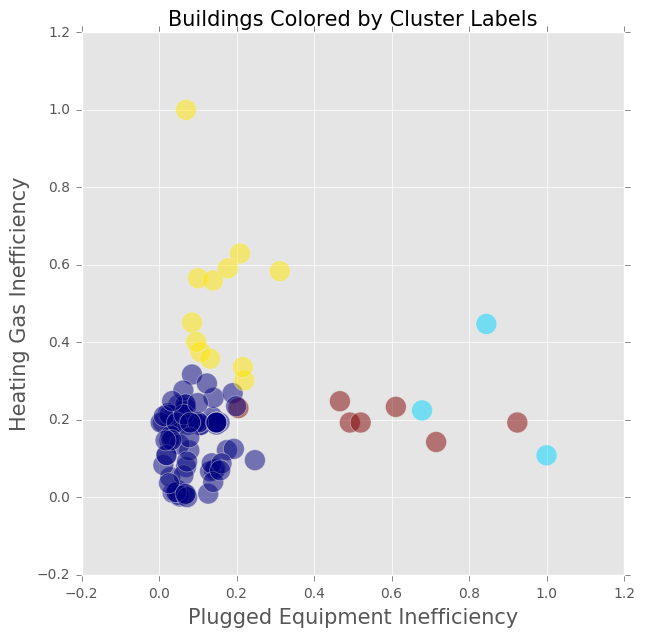

In [20]:
# inefficiency dimensions: ['plug_load_consumption','ac_consumption','domestic_gas','heating_gas']
x = dfCH_n['plug_load_consumption'] 
y = dfCH_n['heating_gas'] 
plt.scatter(x, y, s=225, c=labels, alpha=0.5)
plt.gcf().set_size_inches( (7, 7) )
plt.xlabel('Plugged Equipment Inefficiency',fontsize=15)
plt.ylabel('Heating Gas Inefficiency',fontsize=15)
tt = 'Buildings Colored by Cluster Labels' 
plt.title(tt,fontsize=15)
plt.show()

## The clustering model helps us identify inefficient groups of buildings 

+ Note that in the above figure, most buildings are part of the purple cluster.
+ Buildings labeled with brown, yellow, and blue are more inefficient than the ones that are part of the purple cluster.
+ Labels are re-coded into a binary variable where 1 is inefficient (brown, yellow or blue clusters) and 0 otherwise (purple cluster).

In [21]:
# define binary variable to identify inefficient buildings
label_binary = []
for v in labels:
    label_binary.append(0 if (v == 0) else 1)
label_binary = np.asarray(label_binary)

## Classification model to identify the inefficient buildings

In [22]:
# declare a logistic regression model 
log = linear_model.LogisticRegression(tol = 0.00001, max_iter = 100)
# fit model with our data
log.fit(featReduced, label_binary)
# compute accuracy of the trained model
accuracy = log.score(featReduced, label_binary)
# compute predictions using trained model
y_pred = log.predict(featReduced)
print "Model Accuracy: ", accuracy

Model Accuracy:  0.864077669903


In [23]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['efficient','inefficient'], rotation=0)
    plt.yticks(tick_marks, ['efficient','inefficient'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Confusion matrices allow us to analyze the results of our classifier

+ The 1st row of the confusion matrix, we notice that our model is very good to predict the efficient buildings
+ The 2nd row tells us that our model is not very accurate to identify inefficient buildings (only 8 out of the 22 inefficient buildings were predicted correctly by our model)

Confusion matrix, without normalization
[[81  0]
 [14  8]]


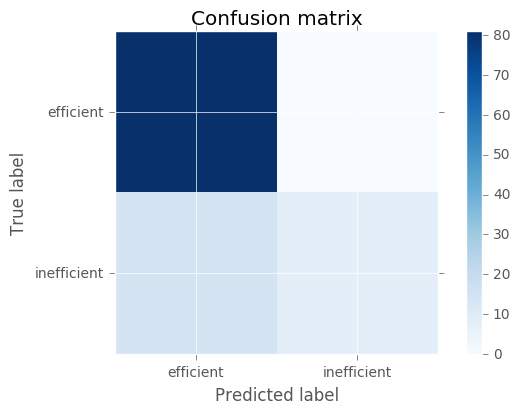

In [24]:
# import confusion matrix to explore model accuracy
from sklearn.metrics import confusion_matrix
# compute confusion matrix
cm = confusion_matrix(label_binary, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# 4. Export data and models to RStudio
We built a 
_[Shiny app](https://ibmdatascience.shinyapps.io/SparkSummitDemo/)_ that summarizes our insights.

### Add credentials for Object Storage container name

1. Click inside the empty cell below to activate it
2. On the right hand data panel, click "Insert to code" under any of the files shown and select "Credentials". 
<div><br><img src="https://raw.githubusercontent.com/IBMDataScience/SparkSummitDemo/master/Screenshots/Screen%20Shot%202016-12-22%20at%201.01.56%20PM.png" width=200 /><br></div>
3. **Now rename the variable that was inserted to be called `credentials`.** This will be referenced in the last code cell to put your data in the right Object Storage container.
4. Run the code cells below to export to a file in your container called `export_data.csv`


In [25]:
fileNameOut = 'swift://'+ credentials['container'] + '.' + name + "/export_data.csv"
dfOut.write.format('com.databricks.spark.csv').options(header='true').save(fileNameOut)